# 1. Import Libraries

In [1]:
import tensorflow as tf
gpu = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpu[0], True)

In [2]:
import math
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
sns.set_style("whitegrid")
plt.style.use("fivethirtyeight")

from collections import Counter
from tqdm.notebook import tqdm
tqdm.pandas()

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE

from tensorflow import keras
from keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import SGD, Adam,  RMSprop, Nadam
from tensorflow.python.keras import models, layers, optimizers
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Flatten, Conv1D, MaxPooling1D, LSTM, GRU, Embedding,\
    BatchNormalization, LeakyReLU, Dropout, ReLU, Bidirectional, GlobalMaxPooling1D

from sklearn.model_selection import train_test_split
from   sklearn.model_selection import cross_val_score

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PowerTransformer, MinMaxScaler, LabelEncoder
from sklearn.feature_selection import chi2, RFE, SelectFromModel, SelectKBest
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, RocCurveDisplay, classification_report 

from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import PassiveAggressiveClassifier, LogisticRegression

from sklearn.ensemble import (
    BaggingClassifier,
    StackingClassifier,
    AdaBoostClassifier, 
    ExtraTreesClassifier,
    RandomForestClassifier,
    RandomForestClassifier,
    GradientBoostingClassifier, 
    HistGradientBoostingClassifier
)
from xgboost import XGBClassifier

from pycaret.classification import ClassificationExperiment



# 2. Load Data

In [3]:
data = pd.read_table('../Dataset/human_data.txt')
data

,sequence,class
0,ATGCCCCAACTAAATACTACCGTATGGCCCACCATAATTACCCCCA...,4
1,ATGAACGAAAATCTGTTCGCTTCATTCATTGCCCCCACAATCCTAG...,4
2,ATGTGTGGCATTTGGGCGCTGTTTGGCAGTGATGATTGCCTTTCTG...,3
3,ATGTGTGGCATTTGGGCGCTGTTTGGCAGTGATGATTGCCTTTCTG...,3
4,ATGCAACAGCATTTTGAATTTGAATACCAGACCAAAGTGGATGGTG...,3
...,...,...
4375,ATGGAAGATTTGGAGGAAACATTATTTGAAGAATTTGAAAACTATT...,0
4376,ATGCAGTCCTTTCGGGAGCAAAGCAGTTACCACGGAAACCAGCAAA...,6
4377,ATGCAGTCCTTTCGGGAGCAAAGCAGTTACCACGGAAACCAGCAAA...,6
4378,ATGGGGCACCTGGTTTGCTGTCTGTGTGGCAAGTGGGCCAGTTACC...,6


# 3. Initial Analysis

### 3.1. Metadata

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4380 entries, 0 to 4379
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   sequence  4380 non-null   object
 1   class     4380 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 68.6+ KB


In [5]:
data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
class,4380.0,3.504566,2.132134,0.0,2.0,4.0,6.0,6.0


In [6]:
data.isnull().sum()

sequence    0
class       0
dtype: int64

In [7]:
print(f'Number of duplicates data : {data.duplicated().sum()}')

Number of duplicates data : 751


In [8]:
data.nunique()

sequence    3629
class          7
dtype: int64

[Text(0, 0, '531'),
 Text(0, 0, '534'),
 Text(0, 0, '349'),
 Text(0, 0, '672'),
 Text(0, 0, '711'),
 Text(0, 0, '240'),
 Text(0, 0, '1343')]

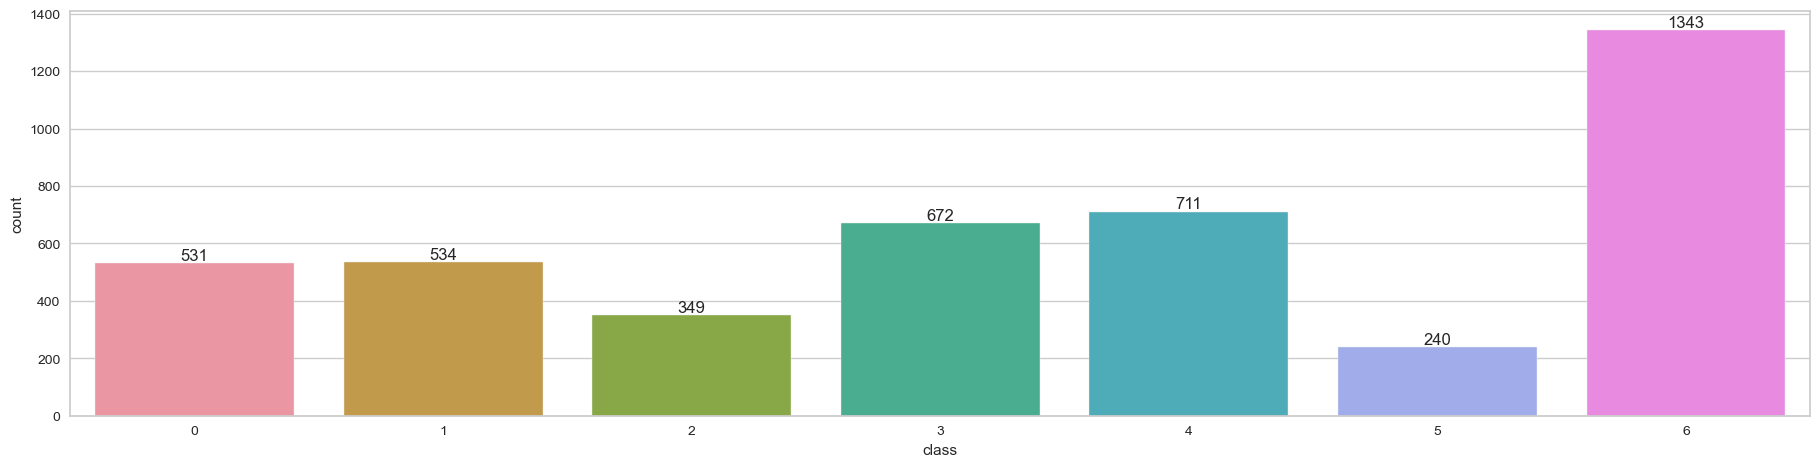

In [9]:
plt.subplots(figsize=(20,5))
ax = sns.countplot(data, x=data['class'])
ax.bar_label(ax.containers[0])

### 3.2. Columns Processing

In [10]:
def getKmers(sequence, size=6):
    return [sequence[x:x+size].lower() for x in range(len(sequence) - size + 1)]

data['words'] = data.apply(lambda x: getKmers(x['sequence']), axis=1)
data = data.drop('sequence', axis=1)

In [11]:
human_texts = list(data['words'])
for item in range(len(human_texts)):
    human_texts[item] = ' '.join(human_texts[item])
Y = data.iloc[:, 0].values

In [14]:
# numerical_columns = [column_name for column_name in data.columns if data[column_name].dtype != 'object']
# categorical_columns = [column_name for column_name in data.columns if data[column_name].dtype == 'object']
# print(f'Numerical Columns   : {numerical_columns}')
# print(f'Categorical Columns : {categorical_columns}')

Numerical Columns   : ['class']
Categorical Columns : ['words']


In [ ]:
# def change_columns_to_numerical(data):
#     LE = LabelEncoder()

#     for column in categorical_columns:
#         data[column] = LE.fit_transform(data[column])
#         data[column] = data[column].astype('int8')
#         print(f'{column} : {LE.classes_}') 
#     return data

# data = change_columns_to_numerical(data)

### 3.3. EDA

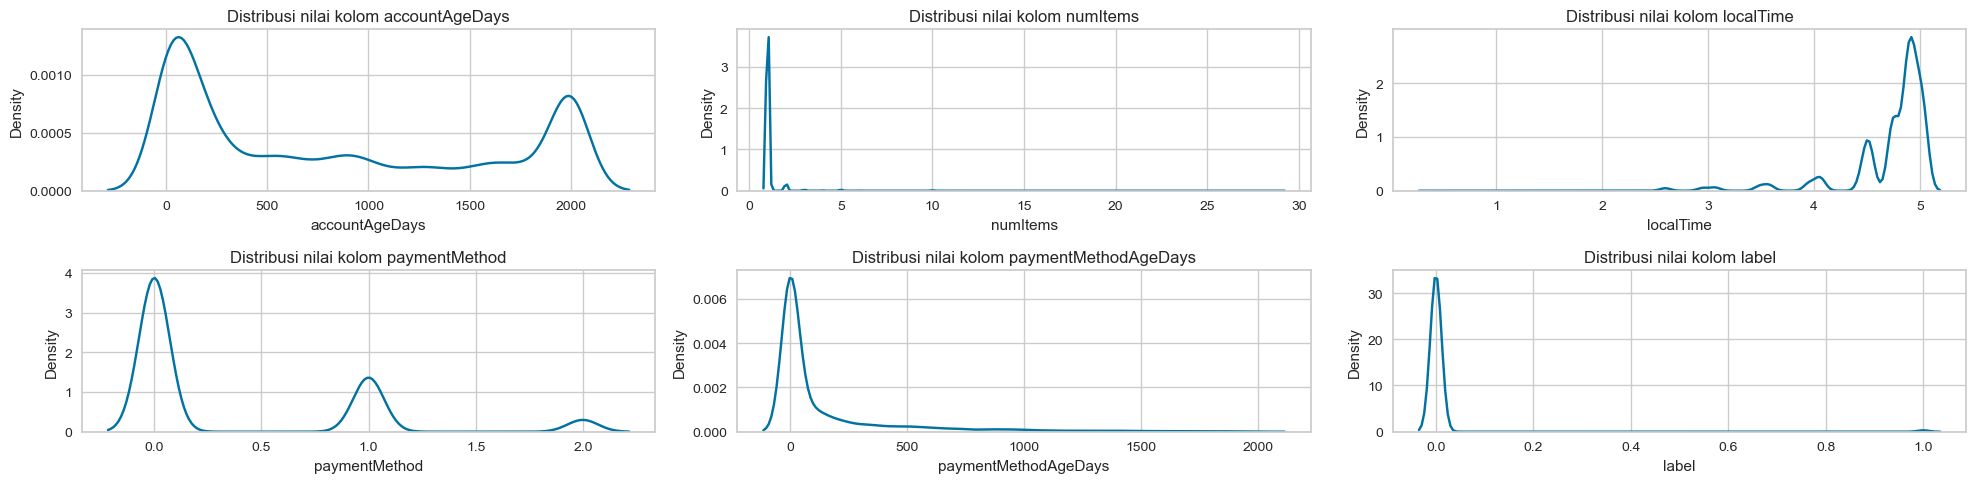

In [17]:
num_cols = 3
num_rows = math.ceil(len(numerical_columns) / num_cols)

fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 5))

for i, column in enumerate(numerical_columns):
    row = i // num_cols
    col = i % num_cols
    sns.kdeplot(data = data, x = column, ax=axes[row, col]) \
        .set_title("Distribusi nilai kolom " + column)
    

for i in range(len(numerical_columns), num_rows * num_cols):
    row = i // num_cols
    col = i % num_cols
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()

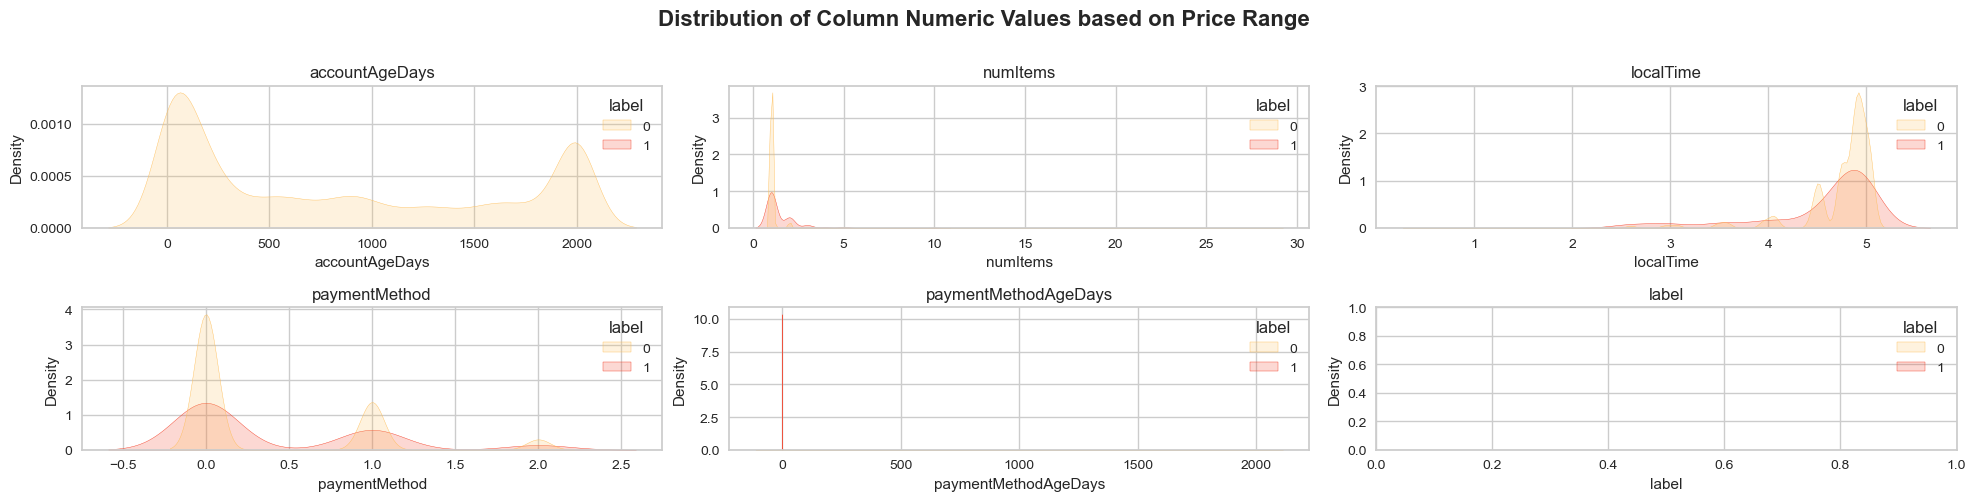

In [18]:
num_cols = 3
num_rows = math.ceil(len(numerical_columns) / num_cols)

fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 5))

for i, column in enumerate(numerical_columns):
    row = i // num_cols
    col = i % num_cols
    sns.kdeplot(data=data, x=column, hue="label", 
                fill=True, alpha=.2, palette="YlOrRd", 
                common_norm=False, ax=axes[row, col],
                warn_singular=False)\
        .set_title(column)

for i in range(len(numerical_columns), num_rows * num_cols):
    row = i // num_cols
    col = i % num_cols
    axes[row, col].axis('off')

fig.suptitle('Distribution of Column Numeric Values based on Price Range', y=1.0, fontsize=16, fontweight='bold')

plt.tight_layout()
plt.show()

In [ ]:
# plt.figure(figsize=(20, 10))

# plt.scatter(data.age[data.target==1],
#             data.thalach[data.target==1],
#             c="salmon")

# plt.scatter(data.age[data.target==0],
#             data.thalach[data.target==0],
#             c="lightblue")

# plt.title("Heart Disease in function of Age and Max Heart Rate")
# plt.xlabel("Age")
# plt.ylabel("Max Heart Rate")
# plt.legend(["Disease", "No Disease"])

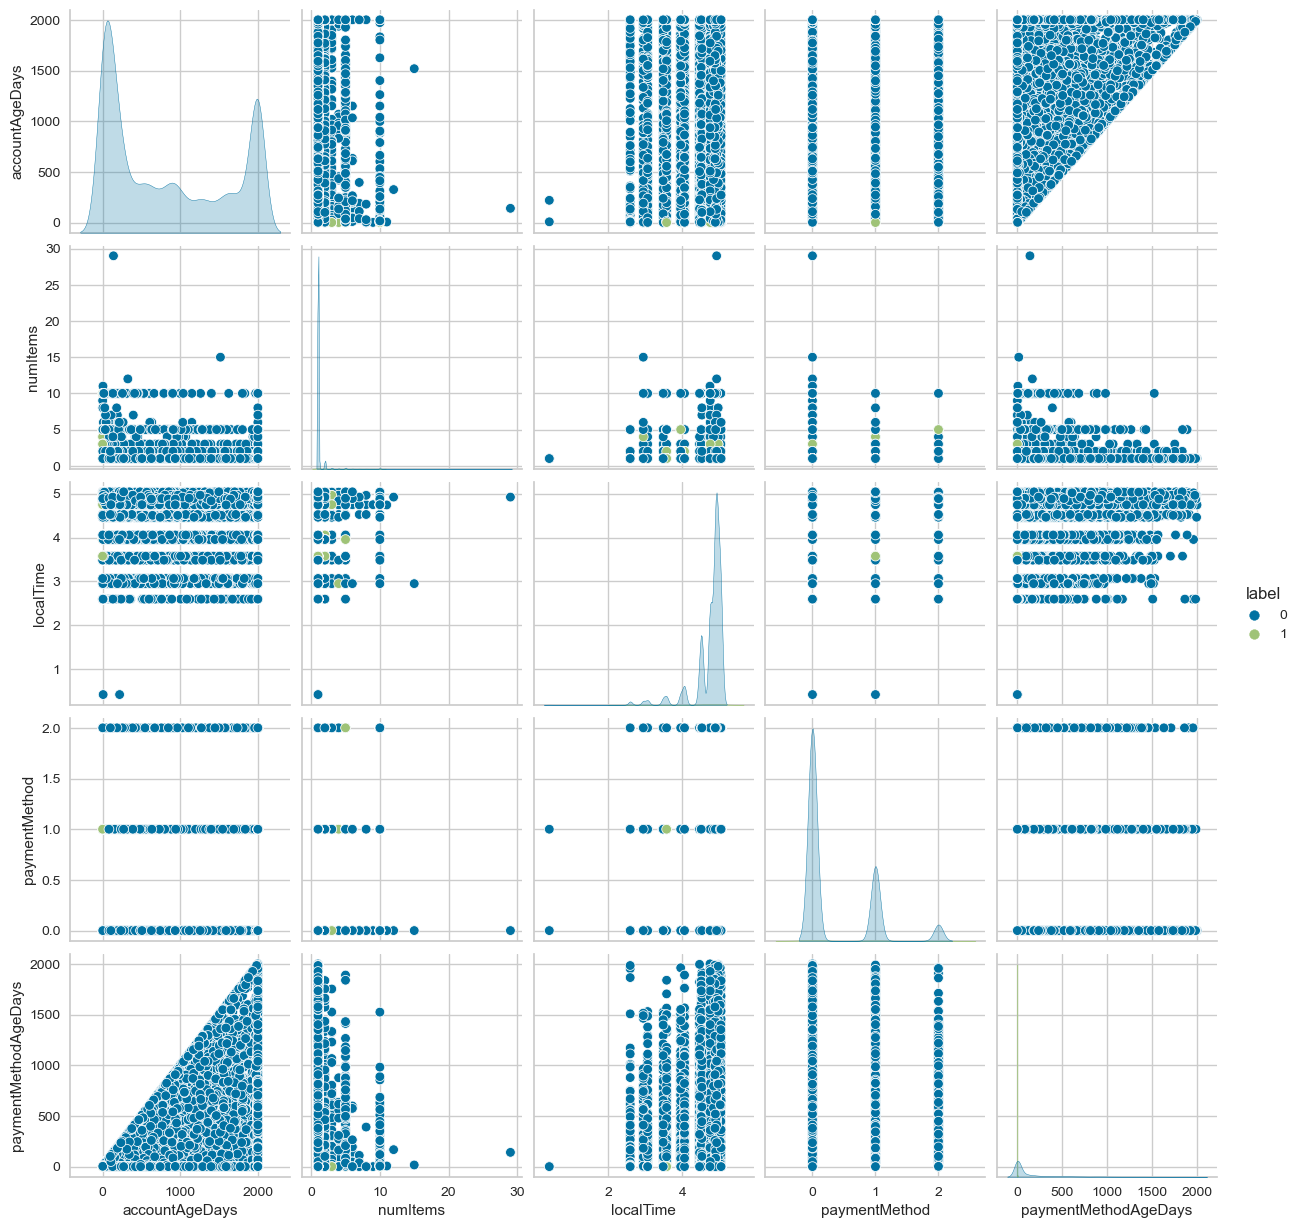

In [19]:
sns.pairplot(data, hue='label')

[Text(0, 0, '33201'), Text(0, 0, '294')]

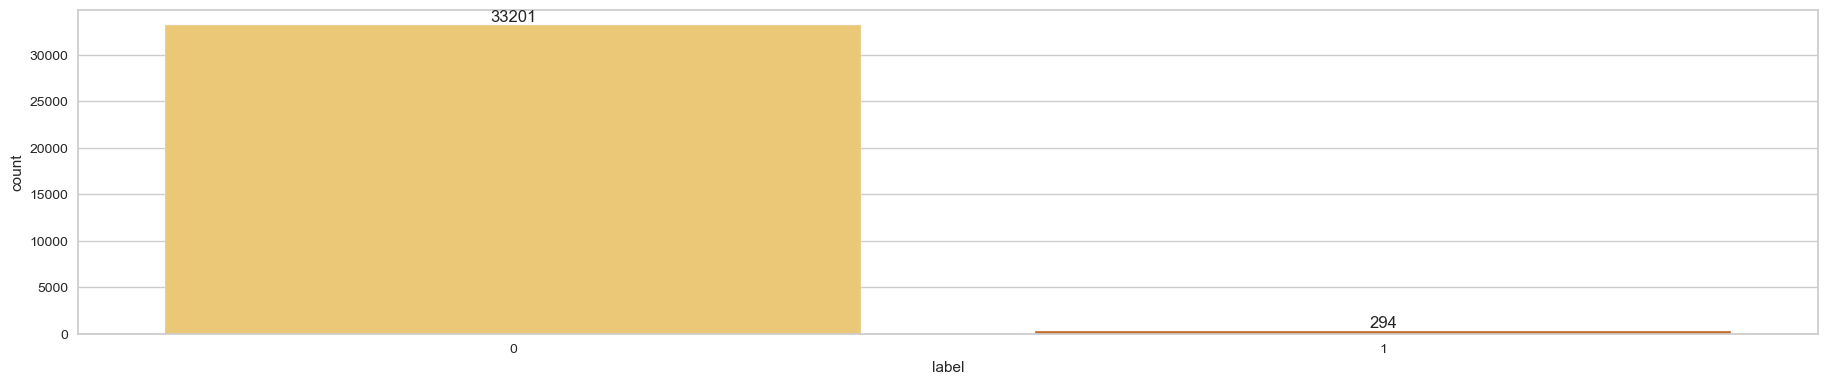

In [21]:
plt.subplots(figsize = (20,4))
ax = sns.countplot(data = data, x = 'label', palette='YlOrBr')
ax.bar_label(ax.containers[0])

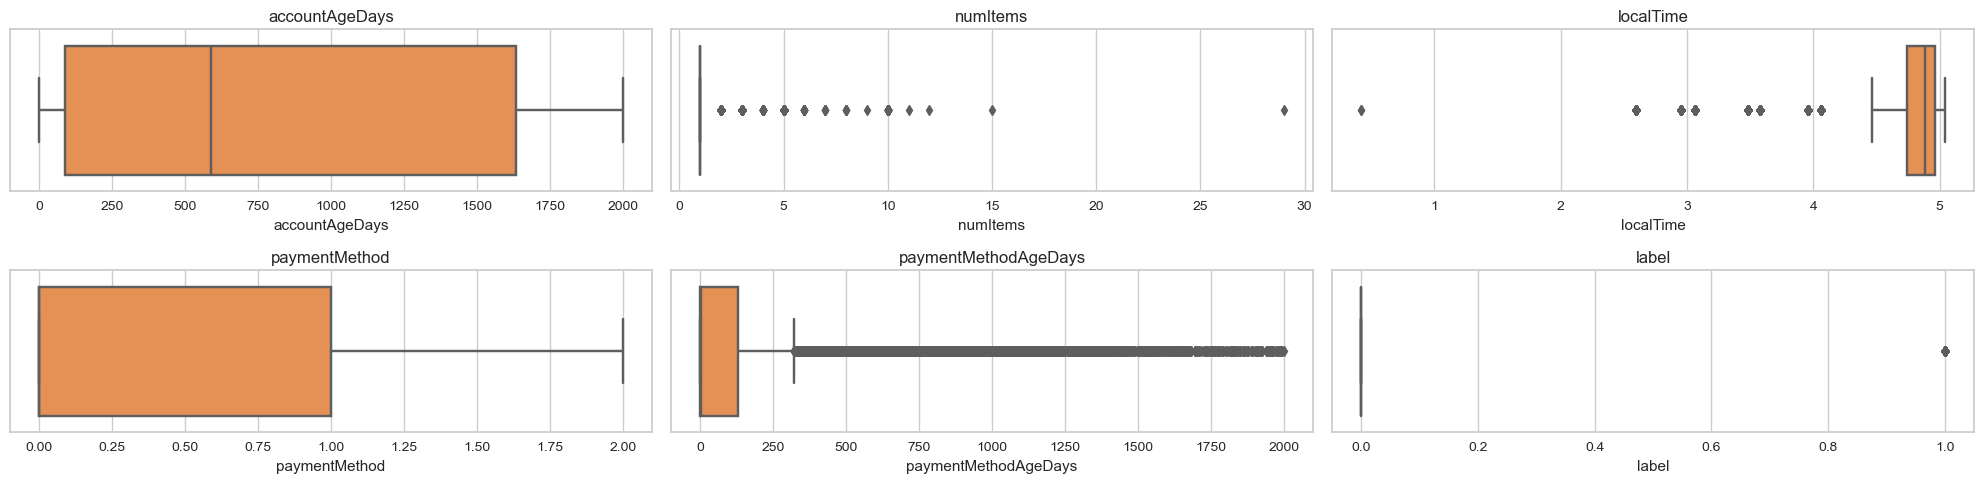

In [22]:
num_cols = 3
num_rows = math.ceil(len(numerical_columns) / num_cols)

fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 5))
for i, column in enumerate(numerical_columns):
    row = i // num_cols
    col = i % num_cols
    sns.boxplot(x=data[column], ax=axes[row, col], palette="Oranges").set_title(column)
    
for i in range(len(numerical_columns), num_rows * num_cols):
    row = i // num_cols
    col = i % num_cols
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()

In [132]:
# Q1 = data['text_len'].quantile(0.25)
# Q3 = data['text_len'].quantile(1.)

# print(Q1)
# print(Q3)

# data = data[(data['text_len'] > Q1) & (data['text_len'] < Q3)]

# fig, axes = plt.subplots(figsize=(25, 2))
# sns.boxplot(x = data['text_len'], palette="Oranges")

# sns.stripplot(x=data['text_len'], data=data,
#               size=4, color=".3", linewidth=0, palette="crest", hue=data['text_len'])

### 3.4. Data Correlation

Text(0.5, 1.0, 'Correlation Matrix')

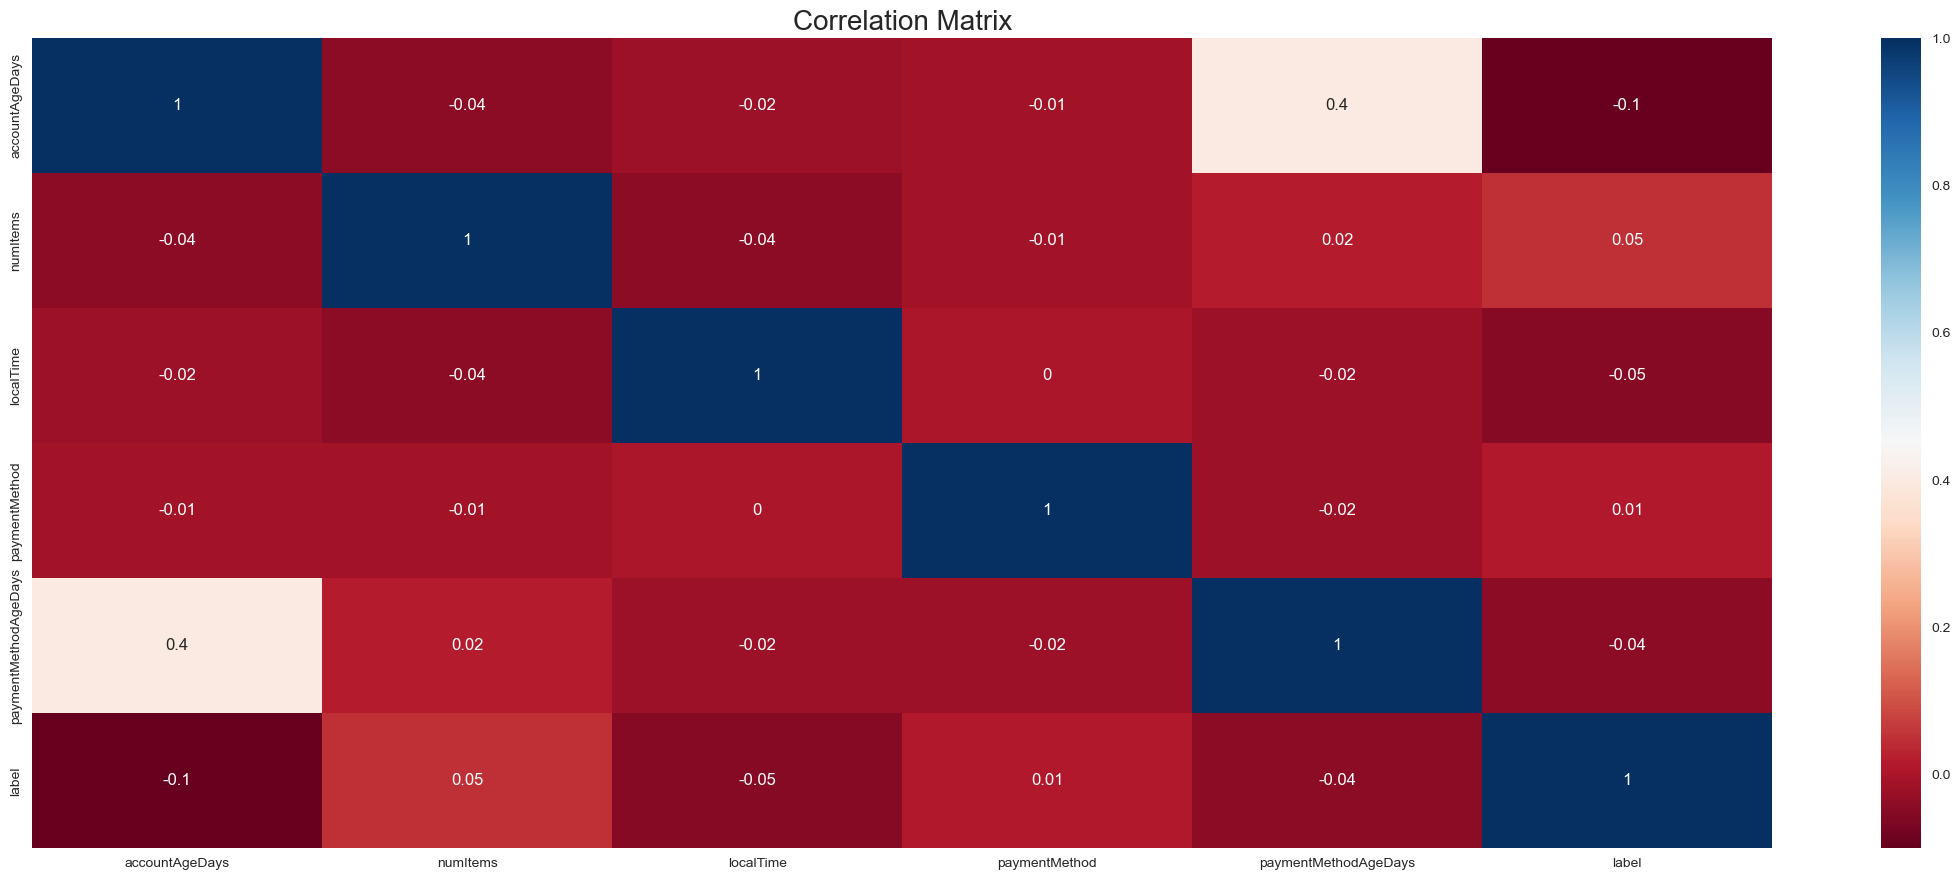

In [23]:
corr_data = data[numerical_columns].corr().round(2)

mask = np.zeros_like(corr_data)
mask[np.triu_indices_from(mask)] = True

plt.figure(figsize=(25, 10))
# sns.heatmap(corr_data, annot=True, mask=mask, cmap='RdBu')
sns.heatmap(corr_data, annot=True, cmap='RdBu')
plt.title("Correlation Matrix", size=20)

# 4. Data Preprocessing

### 4.1. Features Selections

In [266]:
### Pearson Correlation
def cor_selector(X, y,num_feats):
    cor_list = []
    feature_name = X.columns.tolist()
    # calculate the correlation with y for each feature
    for i in X.columns.tolist():
        cor = np.corrcoef(X[i], y)[0, 1]
        cor_list.append(cor)
    # replace NaN with 0
    cor_list = [0 if np.isnan(i) else i for i in cor_list]
    # feature name
    cor_feature = X.iloc[:,np.argsort(np.abs(cor_list))[-num_feats:]].columns.tolist()
    # feature selection? 0 for not select, 1 for select
    cor_support = [True if i in cor_feature else False for i in feature_name]
    print(str(len(cor_feature)), 'selected features')
    print(cor_feature)
    return cor_feature

### Chi-Squared
def chi_squared_elimination(X, Y,num_feats):
    X_norm = MinMaxScaler().fit_transform(X)
    chi_selector = SelectKBest(chi2, k=num_feats)
    chi_selector.fit(X_norm, Y)
    chi_support = chi_selector.get_support()
    chi_feature = X.loc[:,chi_support].columns.tolist()
    print(str(len(chi_feature)), 'selected features')
    print(chi_feature)
    return chi_feature

### Recursive Feature Elimination
def recursive_elimination(X, Y,num_feats):
    X_norm = MinMaxScaler().fit_transform(X)
    rfe_selector = RFE(estimator=LogisticRegression(), n_features_to_select=num_feats, step=10, verbose=5)
    rfe_selector.fit(X_norm, Y)
    rfe_support = rfe_selector.get_support()
    rfe_feature = X.loc[:,rfe_support].columns.tolist()
    print(str(len(rfe_feature)), 'selected features')
    print(rfe_feature)
    return rfe_feature

### Lasso: SelectFromModel
def lasso_elimination(X, Y, num_feats):
    X_norm = MinMaxScaler().fit_transform(X)
    embeded_lr_selector = SelectFromModel(LogisticRegression(penalty="l2"), max_features=num_feats)
    embeded_lr_selector.fit(X_norm, Y)
    embeded_lr_support = embeded_lr_selector.get_support()
    embeded_lr_feature = X.loc[:,embeded_lr_support].columns.tolist()
    print(str(len(embeded_lr_feature)), 'selected features')
    print(embeded_lr_feature)
    return embeded_lr_feature

### LightGBM: SelectFromModel
def LGBMC_elimination(X, Y, num_feats):
    lgbc=LGBMClassifier(n_estimators=500, learning_rate=0.05, num_leaves=32, colsample_bytree=0.2,
                reg_alpha=3, reg_lambda=1, min_split_gain=0.01, min_child_weight=40)

    embeded_lgb_selector = SelectFromModel(lgbc, max_features=num_feats)
    embeded_lgb_selector.fit(X, Y)
    embeded_lgb_support = embeded_lgb_selector.get_support()
    embeded_lgb_feature = X.loc[:,embeded_lgb_support].columns.tolist()
    print(str(len(embeded_lgb_feature)), 'selected features')
    print(embeded_lgb_feature)
    return embeded_lgb_feature

### Tree-based: SelectFromModel
def RFC_elimination (X, Y, num_feats):
    embeded_rf_selector = SelectFromModel(RandomForestClassifier(n_estimators=100), max_features=num_feats)
    embeded_rf_selector.fit(X, Y)

    embeded_rf_support = embeded_rf_selector.get_support()
    embeded_rf_feature = X.loc[:,embeded_rf_support].columns.tolist()
    print(str(len(embeded_rf_feature)), 'selected features')
    print(embeded_rf_feature)
    return embeded_rf_feature

In [271]:
X = data.drop(columns=['Potability'])
Y = data['Potability']

num_feats = 10

selected_feature = cor_selector(X, Y,num_feats)
# selected_feature = chi_squared_elimination(X, Y,num_feats)
# selected_feature = recursive_elimination(X, Y,num_feats)
# selected_feature = lasso_elimination(X, Y, num_feats)
# selected_feature = LGBMC_elimination(X, Y, num_feats)
# selected_feature = RFC_elimination(X, Y, num_feats)

X = data[selected_feature]
Y = data['Credit_Score']


print(Counter(Y))
undersample = RandomUnderSampler()
X, Y = undersample.fit_resample(X, Y)
print(Counter(Y))

Y = to_categorical(Y)

scaler = MinMaxScaler(feature_range=(0,1))
X = scaler.fit_transform(X)

X_train, X_val, y_train, y_val = train_test_split(X, Y, train_size=0.9, random_state = 42)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, train_size=0.78, random_state = 42)

print(X_train.shape)
print(X_test.shape)
print(X_val.shape)

10 selected features
['Monthly_Balance', 'Num_Bank_Accounts', 'Credit_History_Age', 'Num_Credit_Card', 'Num_of_Loan', 'Delay_from_due_date', 'Outstanding_Debt', 'Interest_Rate', 'Num_Credit_Inquiries', 'Credit_Mix']
Counter({0: 53174, 2: 28998, 1: 17828})
Counter({0: 17828, 1: 17828, 2: 17828})
(37545, 10)
(10590, 10)
(5349, 10)


### 4.2. Text Processing

In [ ]:
vocab_size = 10_000
embedding_dim = 128
max_length = 470
trunc_type = 'post'
padding_type = 'post'
oov_tok = "<OOV>"
num_label = y_train.shape[1]

In [ ]:
# Tokenizing 
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(X)

print(len(tokenizer.word_index))

# Text to Sequences
training_sequences = tokenizer.texts_to_sequences(X_train)
testing_sequences = tokenizer.texts_to_sequences(X_test)
validating_sequences = tokenizer.texts_to_sequences(X_val)

# Add padding
training_padded = pad_sequences(training_sequences, maxlen = max_length, padding = padding_type)
testing_padded = pad_sequences(testing_sequences, maxlen = max_length, padding = padding_type)
validating_padded = pad_sequences(validating_sequences, maxlen = max_length, padding = padding_type)

# Convert to numpy array
training_padded = np.array(training_padded)
training_label = np.array(y_train)

testing_padded = np.array(testing_padded)
testing_label = np.array(y_test)

validating_padded = np.array(validating_padded)
validating_label = np.array(y_val)

# Undersampling
rus = RandomUnderSampler(random_state=42, replacement=True)# fit predictor and target variable

training_padded, training_label = rus.fit_resample(training_padded, training_label)
testing_padded, testing_label = rus.fit_resample(testing_padded, testing_label)
validating_padded, validating_label = rus.fit_resample(validating_padded, validating_label)

# Categorical Label
training_label = pd.get_dummies(training_label.reshape(-1)).values
testing_label = pd.get_dummies(testing_label.reshape(-1)).values
validating_label = pd.get_dummies(validating_label.reshape(-1)).values

print(training_padded.shape)
print(testing_padded.shape)
print(validating_padded.shape)


In [12]:
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(ngram_range=(4,4))
X = cv.fit_transform(human_texts)
# X_chimp = cv.transform(chimp_texts)
# X_dog = cv.transform(dog_texts)
print(X.shape)
# print(X_chimp.shape)
# print(X_dog.shape)

(4380, 232414)


# 5 Neural Network Algoritms

In [13]:

# X = data.drop(columns=['label']).values
# Y = data['label']

# print(Counter(Y))
# # sampling = RandomUnderSampler()
# sampling = SMOTE()
# X, Y = sampling.fit_resample(X, Y)
# print(Counter(Y))

Y = pd.get_dummies(Y).values

# scaler = MinMaxScaler(feature_range=(0,1))
# scaler = PowerTransformer(method='yeo-johnson', standardize=True)
# X = scaler.fit_transform(X)

X_train, X_val, y_train, y_val = train_test_split(X, Y, train_size=0.9, random_state = 42)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, train_size=0.78, random_state = 42)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)
print(X_val.shape, y_val.shape)

label = y_train.shape[1]

(3074, 232414) (3074, 7)
(868, 232414) (868, 7)
(438, 232414) (438, 7)


In [16]:
def DNN_Model():
    model = Sequential()
    model.add(Dense(1024, activation='relu', kernel_regularizer=keras.regularizers.l2(l=0.001), input_shape=(X_train.shape[1],)))
    model.add(Dense(256, activation='relu', kernel_regularizer=keras.regularizers.l2(l=0.001)))
    model.add(Dense(64, activation='relu', kernel_regularizer=keras.regularizers.l2(l=0.001)))
    model.add(Dense(label, activation='softmax'))
    
    return model

def CNN_Model():
    model = Sequential()

    model.add(Conv1D(128, 3, kernel_regularizer=keras.regularizers.l2(l=0.001), input_shape=(X_train.shape[1], 1)))
    model.add(BatchNormalization())
    # model.add(LeakyReLU(0.2))
    model.add(ReLU())
    # model.add(Dropout(0.8))
    model.add(MaxPooling1D())

    # model.add(Conv1D(64, 3, kernel_regularizer=keras.regularizers.l2(l=0.001)))
    # model.add(BatchNormalization())
    # # model.add(LeakyReLU(0.2))
    # model.add(ReLU())
    # model.add(Dropout(0.5))
    # model.add(MaxPooling1D())

    model.add(Conv1D(64, 3, kernel_regularizer=keras.regularizers.l2(l=0.001)))
    model.add(BatchNormalization())
    # model.add(LeakyReLU(0.2))
    model.add(ReLU())
    # model.add(Dropout(0.5))
    model.add(MaxPooling1D())

    # model.add(Conv1D(16, 3, kernel_regularizer=keras.regularizers.l2(l=0.001)))
    # model.add(BatchNormalization())
    # # model.add(LeakyReLU(0.2))
    # model.add(ReLU())
    # # model.add(Dropout(0.5))
    # model.add(MaxPooling1D())

    model.add(Flatten())
    # model.add(Dense(4098, activation='relu'))
    model.add(Dense(128, activation='relu'))
    # model.add(Dropout(0.5))
    model.add(Dense(128, activation='relu'))
    # model.add(Dropout(0.5))
    model.add(Dense(label, activation='softmax'))
    return model

def LSTM_Model():
    model = Sequential()
    model.add((LSTM(256, return_sequences=True, input_shape=(X_train.shape[1], 1))))
    model.add((LSTM(256)))
    # model.add(Dense(32, activation='swish'))
    # model.add(Dropout(0.2))
    # model.add(Dropout(0.5))
    # model.add(Dense(16, activation='relu'))
    model.add(Dense(label, activation='sigmoid'))
    return model

def GRU_Model():
    model = Sequential()
    model.add(GRU(32, activation ='tanh', recurrent_activation ='sigmoid', recurrent_dropout = 0, unroll=False, use_bias=True, reset_after=True, return_sequences=True, input_shape = (X_train.shape[1],1)))
    model.add(GRU(32, activation ='tanh', recurrent_activation ='sigmoid', recurrent_dropout = 0, unroll=False, use_bias=True, reset_after=True))
    model.add(Dense(label, activation='softmax'))
    return model
    

model = DNN_Model()
# model = CNN_Model()
# model = LSTM_Model()
# model = GRU_Model()

model.summary()

# opt = RMSprop(learning_rate = 0.001)
# opt = SGD(learning_rate = 0.001)
opt = Adam(learning_rate = 0.001)

model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
# model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

ResourceExhaustedError: {{function_node __wrapped__AddV2_device_/job:localhost/replica:0/task:0/device:GPU:0}} failed to allocate memory [Op:AddV2]

In [15]:
num_epoch = 10
batch_size = 32

history = model.fit(X_train, y_train, 
                    batch_size = batch_size, epochs = num_epoch, 
                    validation_data = (X_test, y_test))

InvalidArgumentError: {{function_node __wrapped__SerializeManySparse_device_/job:localhost/replica:0/task:0/device:CPU:0}} indices[2] = [0,167843] is out of order. Many sparse ops require sorted indices.
    Use `tf.sparse.reorder` to create a correctly ordered copy.

 [Op:SerializeManySparse]

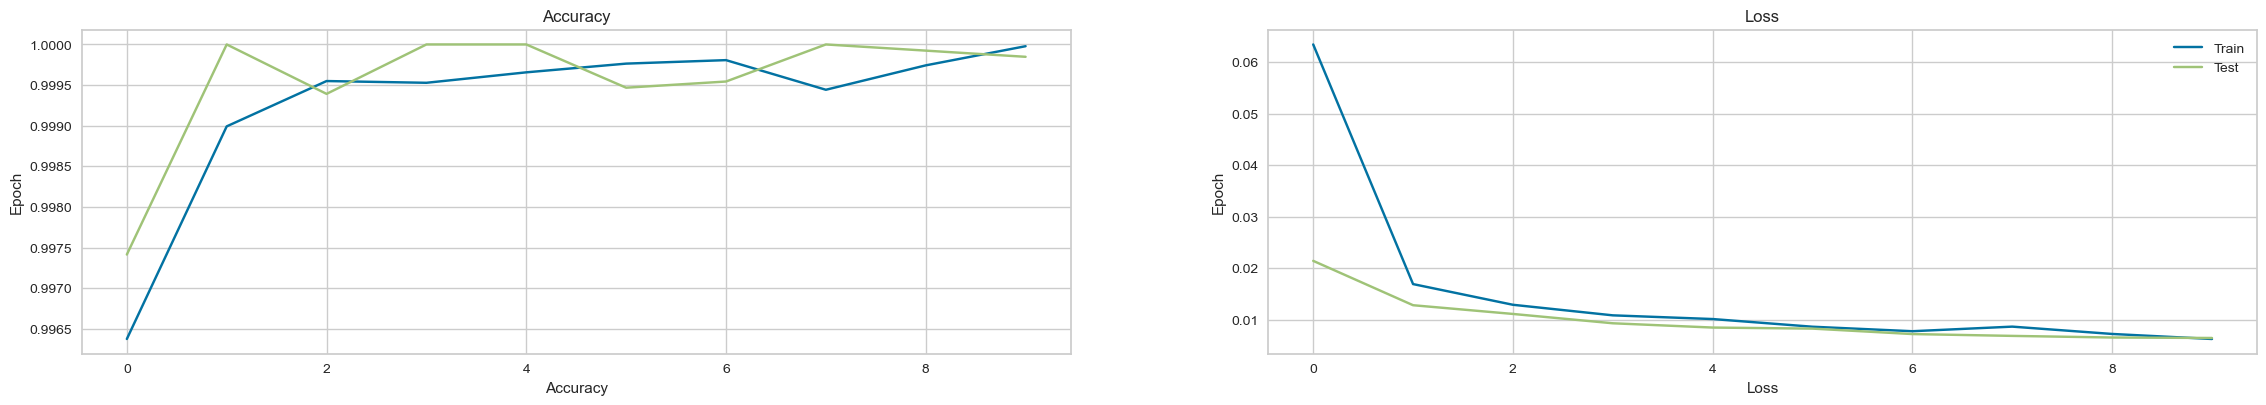

In [28]:
fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(25, 4))
ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])
ax[0].set_title('Accuracy')
ax[0].set_xlabel('Accuracy')
ax[0].set_ylabel('Epoch')

ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_title('Loss')
ax[1].set_xlabel('Loss')
ax[1].set_ylabel('Epoch')

plt.legend(['Train', 'Test'])
plt.show()

In [29]:
from sklearn.metrics import classification_report
y_pred = np.rint(model.predict(X_val, verbose=0))

print(classification_report(y_val,y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3380
           1       1.00      1.00      1.00      3261

   micro avg       1.00      1.00      1.00      6641
   macro avg       1.00      1.00      1.00      6641
weighted avg       1.00      1.00      1.00      6641
 samples avg       1.00      1.00      1.00      6641



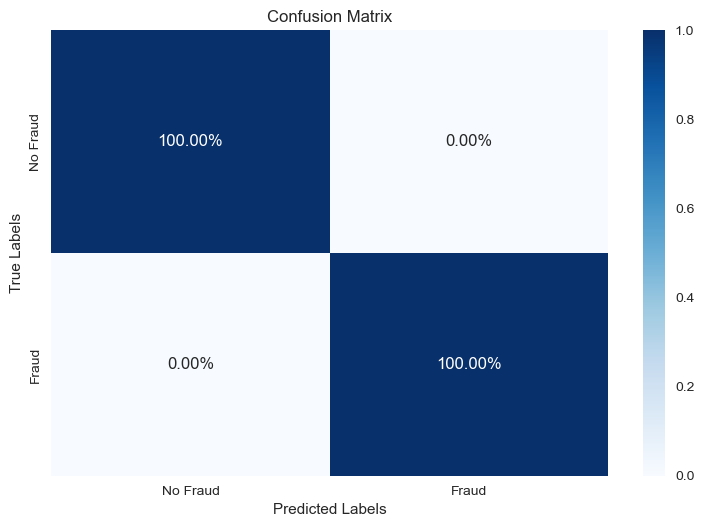

In [31]:
labels = ['No Fraud', 'Fraud']

y_pred = np.rint(model.predict(X_val, verbose=0).argmax(axis=1))
con_mat = confusion_matrix(y_val.argmax(axis=1),y_pred)

cm_percent = con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis]

sns.heatmap(cm_percent, annot=True, fmt='.2%', cmap='Blues', xticklabels=labels, yticklabels=labels)

plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# 6. Supervised Learning

In [32]:
X = data.drop(columns=['label']).values
Y = data['label']

print(Counter(Y))
# undersample = RandomUnderSampler()
undersample = SMOTE()
X, Y = undersample.fit_resample(X, Y)
print(Counter(Y))

Y = Y.values

# scaler = MinMaxScaler(feature_range=(0,1))
scaler = PowerTransformer(method='yeo-johnson', standardize=True)
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, Y, train_size=0.9, random_state = 42)

print(X_train.shape)
print(X_test.shape)

Counter({0: 33201, 1: 294})
Counter({0: 33201, 1: 33201})
(59761, 5)
(6641, 5)


### 6.2 Stacking Classifier

In [33]:
adaboost = AdaBoostClassifier(n_estimators=100, random_state=42)
bagging = BaggingClassifier(n_jobs=-1)
extraTrees = ExtraTreesClassifier(max_depth=100, n_jobs=-1, random_state=42)
gradient = GradientBoostingClassifier(max_depth=100, n_estimators=100, learning_rate=.01,  random_state=42)
randomForest = RandomForestClassifier(max_depth=100, random_state=42, n_jobs=-1)
histGradient = HistGradientBoostingClassifier()
XGB = XGBClassifier(n_jobs=-1)
knn = KNeighborsClassifier(n_jobs=-1)
decisionTree = DecisionTreeClassifier(random_state=42, max_depth=100)
pac = PassiveAggressiveClassifier(random_state=42)
linear = LogisticRegression(random_state=42)

model = StackingClassifier([
    ('bagging', bagging),
    ('adaboost', adaboost),
    ('extraTress', extraTrees),
    ('randomforest', randomForest),
    ('decisionTree', decisionTree),
    ('histGradient', histGradient),
    ('XGB', XGB),
    ('pac', pac),
    ('linear', linear),
    # ('gradient', gradient),
    # ('knn', knn),
], n_jobs=-1)

In [34]:
model.fit(X_train, y_train)

StackingClassifier(estimators=[('bagging', BaggingClassifier(n_jobs=-1)),
                               ('adaboost',
                                AdaBoostClassifier(n_estimators=100,
                                                   random_state=42)),
                               ('extraTress',
                                ExtraTreesClassifier(max_depth=100, n_jobs=-1,
                                                     random_state=42)),
                               ('randomforest',
                                RandomForestClassifier(max_depth=100, n_jobs=-1,
                                                       random_state=42)),
                               ('decisionTree',
                                DecisionTreeClassifier(max_depth=100,
                                                       r...
                                              max_cat_threshold=None,
                                              max_cat_to_onehot=None,
                                              max_delta_step=None,
                                              max_depth=None, max_leaves=None,
                                              min_child_weight=None,
                                              missing=nan,
                                              monotone_constraints=None,
                                              n_estimators=100, n_jobs=-1,
                                              num_parallel_tree=None,
                                              predictor=None, random_state=None, ...)),
                               ('pac',
                                PassiveAggressiveClassifier(random_state=42)),
                               ('linear', LogisticRegression(random_state=42))],
                   n_jobs=-1)

In [35]:
print("Train Score : ",round((model.score(X_train, y_train)*100), 2),'%')
print("Test Score  : ",round((model.score(X_test, y_test)*100), 2),'%')

Train Score :  100.0 %
Test Score  :  100.0 %


In [36]:
y_pred = model.predict(X_test)
print(classification_report(y_pred,y_test))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3380
           1       1.00      1.00      1.00      3261

    accuracy                           1.00      6641
   macro avg       1.00      1.00      1.00      6641
weighted avg       1.00      1.00      1.00      6641



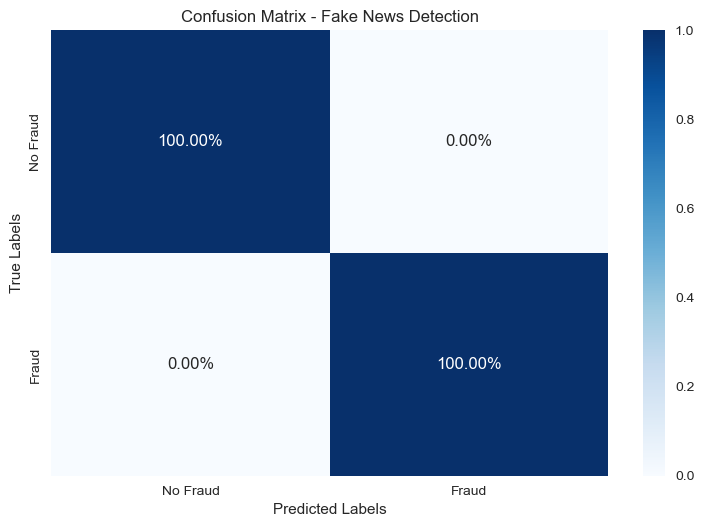

In [37]:
labels = ['No Fraud', 'Fraud']

y_pred = model.predict(X_test)
con_mat = confusion_matrix(y_test,y_pred)

cm_percent = con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis]

sns.heatmap(cm_percent, annot=True, fmt='.2%', cmap='Blues', xticklabels=labels, yticklabels=labels)

plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - Fake News Detection')
plt.show()

### 6.2. Pycaret

In [45]:
s = ClassificationExperiment()
s.setup(data, target = 'target', session_id = 123)

,Description,Value
0,Session id,123
1,Target,target
2,Target type,Binary
3,Original data shape,"(302, 14)"
4,Transformed data shape,"(302, 14)"
5,Transformed train set shape,"(211, 14)"
6,Transformed test set shape,"(91, 14)"
7,Numeric features,13
8,Preprocess,True
9,Imputation type,simple


In [46]:
best = s.compare_models()

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,21:18:11
Status,. . . . . . . . . . . . . . . . . .,Loading Dependencies
Estimator,. . . . . . . . . . . . . . . . . .,Compiling Library


In [ ]:
s.evaluate_model(best)


In [48]:
print(best)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=123, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)


In [49]:
s.predict_model(best)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Logistic Regression,0.8462,0.9082,0.9184,0.8182,0.8654,0.6873,0.6935


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target,prediction_label,prediction_score
300,68,1,0,144,193,1,1,141,0,3.4,1,2,3,0,0,0.9656
276,58,1,0,146,218,0,1,105,0,2.0,1,1,3,0,0,0.9710
84,42,0,0,102,265,0,0,122,0,0.6,1,0,2,1,1,0.6207
141,43,1,0,115,303,0,1,181,0,1.2,1,0,2,1,1,0.6176
226,62,1,1,120,281,0,0,103,0,1.4,1,1,3,0,0,0.9002
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
153,66,0,2,146,278,0,0,152,0,0.0,1,1,2,1,1,0.9173
11,48,0,2,130,275,0,1,139,0,0.2,2,0,2,1,1,0.9615
81,45,1,1,128,308,0,0,170,0,0.0,2,0,2,1,1,0.8216
162,41,1,1,120,157,0,1,182,0,0.0,2,0,2,1,1,0.9372


In [12]:
lgbm = s.create_model('xgboost')

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,18:02:50
Status,. . . . . . . . . . . . . . . . . .,Loading Dependencies
Estimator,. . . . . . . . . . . . . . . . . .,Compiling Library


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7718,0.8167,0.7180,0.7497,0.7335,0.5342,0.5346
1,0.7747,0.8213,0.7183,0.7547,0.7360,0.5396,0.5401
2,0.7757,0.8226,0.7208,0.7552,0.7376,0.5419,0.5424
3,0.7683,0.8147,0.7119,0.7465,0.7288,0.5267,0.5272
4,0.7714,0.8189,0.7178,0.7491,0.7331,0.5334,0.5337
5,0.7700,0.8144,0.7148,0.7482,0.7311,0.5304,0.5308
6,0.7762,0.8220,0.7227,0.7552,0.7386,0.5432,0.5436
7,0.7739,0.8207,0.7208,0.7520,0.7361,0.5385,0.5389
8,0.7744,0.8216,0.7189,0.7538,0.7360,0.5392,0.5397


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

In [13]:
X = data.drop(columns=['satisfaction']).values
Y = data['satisfaction']

In [37]:
scores = cross_val_score(lgbm, X_train, y_train, cv=20)

NameError: name 'X_train' is not defined

<Axes: >

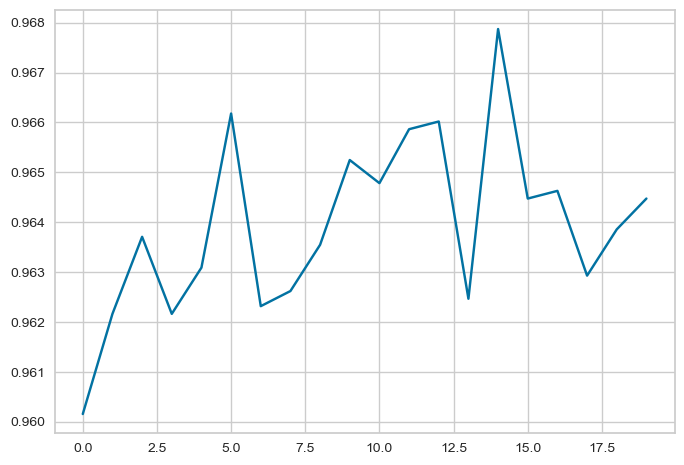

In [22]:
sns.lineplot(scores)

In [16]:
preds = s.predict_model(lgbm)
preds

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Extreme Gradient Boosting,0.7745,0.8197,0.7199,0.7531,0.7362,0.5394,0.5399


In [36]:
pred = (abs(preds['satisfaction'] - preds['prediction_label'])).sum()

print(f'{pred} / {preds.shape[0]} : {round(pred/preds.shape[0]*100, 2)} % (False Predictions)')

33248 / 147438 : 22.55 % (False Predictions)
